In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cybersecurity-suspicious-web/CloudWatch_Traffic_Web_Attack.csv


# Data Loading and Preprocessing

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

# Set plot style
sns.set(style='whitegrid')

# Load Dataset
df = pd.read_csv('/kaggle/input/cybersecurity-suspicious-web/CloudWatch_Traffic_Web_Attack.csv')
df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

In [47]:
df.isnull().sum()

bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64

# Data Preprocessing

In [48]:
df['creation_time'] = pd.to_datetime(df['creation_time'], errors='coerce')
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Exploratory Data Analysis (EDA)

**Bytes In/Out Distribution**

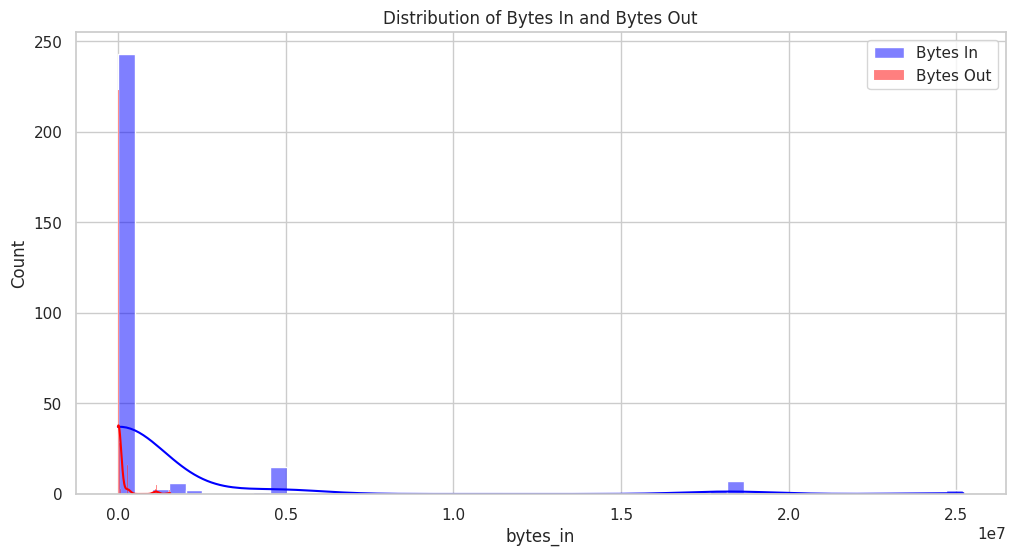

In [49]:
plt.figure(figsize=(12, 6))
sns.histplot(df['bytes_in'], color='blue', kde=True, bins=50, label='Bytes In')
sns.histplot(df['bytes_out'], color='red', kde=True, bins=50, label='Bytes Out')
plt.title("Distribution of Bytes In and Bytes Out")
plt.legend()
plt.show()


The vast majority of "Bytes In" and "Bytes Out" events occur at low byte values, as indicated by the high bars near the left side of the x-axis.

There are a few instances with very high byte values (outliers), but these are rare compared to the bulk of the data.

The "Bytes In" distribution (blue) has higher counts overall, suggesting that inbound traffic is more frequent or larger in volume than outbound traffic in this dataset.

Both distributions follow a similar pattern, but "Bytes In" appears slightly more spread out, with more pronounced outliers at higher values.

**Protocol Count**

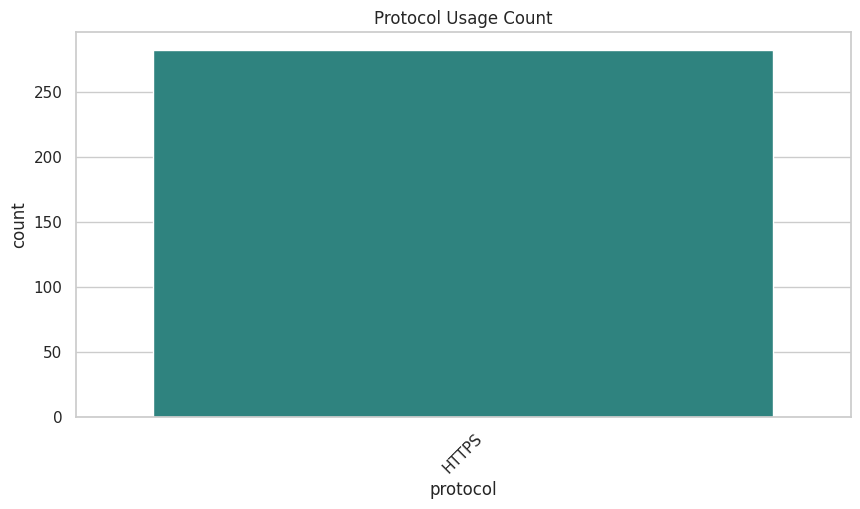

In [50]:
plt.figure(figsize=(10, 5))
sns.countplot(x='protocol', data=df, palette='viridis')
plt.title('Protocol Usage Count')
plt.xticks(rotation=45)
plt.show()

HTTPS is the sole protocol observed in this dataset, suggesting that all recorded network traffic uses secure HTTP communication.

The absence of other protocols (such as HTTP, FTP, or others) indicates a strong preference or enforcement for secure, encrypted traffic.

The high count for HTTPS demonstrates its dominance and possibly a security policy that mandates encrypted connections.

# Feature Engineering

In [51]:
# Session Duration
df['session_duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
df['session_duration'].replace(0, 0.001, inplace=True) #This represents the total time a session was active.

# Average Packet Size
df['avg_packet_size'] = (df['bytes_in'] + df['bytes_out']) / df['session_duration'] #Estimates the average amount of data exchanged per second during a session.

# Country and Port Based Insights

**Source IP Country Count**

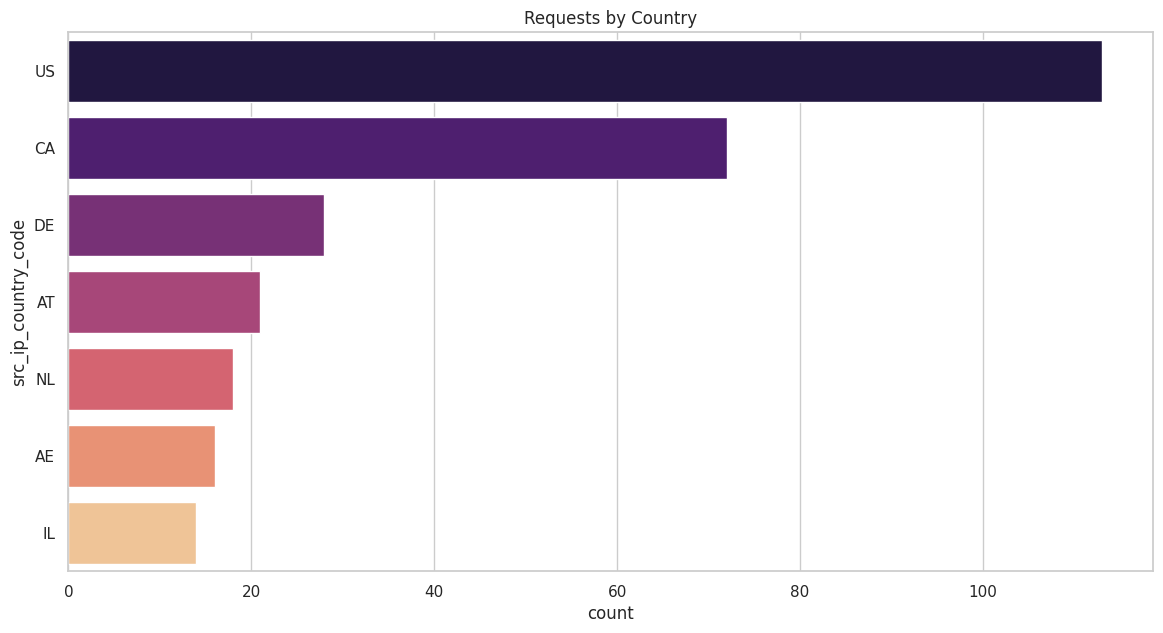

In [52]:
plt.figure(figsize=(14, 7))
sns.countplot(y='src_ip_country_code', data=df, order=df['src_ip_country_code'].value_counts().index, palette='magma')
plt.title("Requests by Country")
plt.show()

**Suspicious Destination Ports**

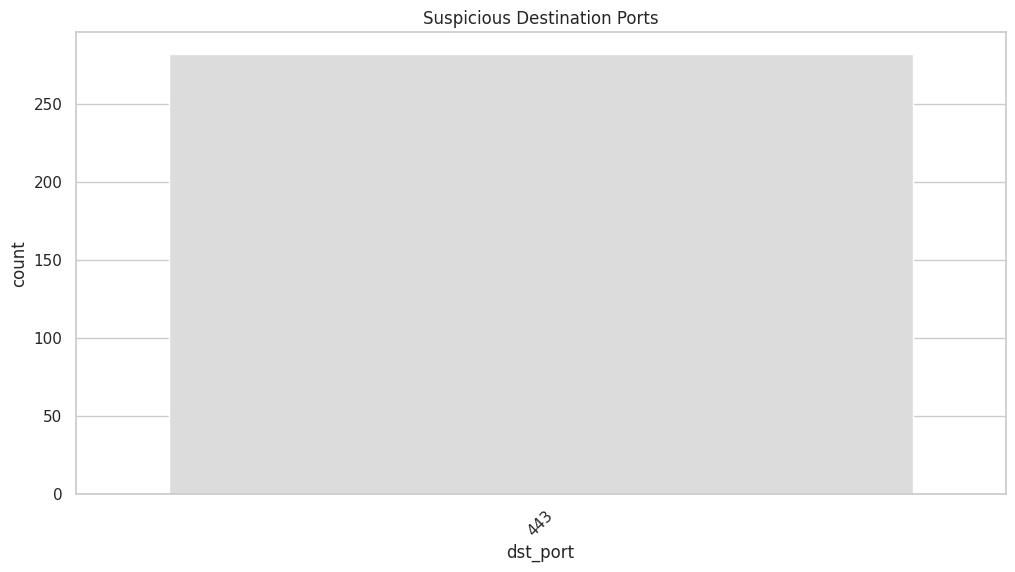

In [53]:
plt.figure(figsize=(12, 6))
sns.countplot(x='dst_port', data=df[df['detection_types'] == 'waf_rule'], palette='coolwarm')
plt.title("Suspicious Destination Ports")
plt.xticks(rotation=45)
plt.show()

All detected suspicious network activity is concentrated on destination port 443, which is used for HTTPS (secure web traffic), with around 280 events recorded. This suggests that potential threats in this dataset are exclusively targeting encrypted web services, possibly attempting to exploit vulnerabilities under the cover of secure communication. No suspicious events were observed on any other ports, indicating a strong focus—either by attackers or by monitoring efforts—on HTTPS traffic.

# Anomaly Detection using Isolation Forest

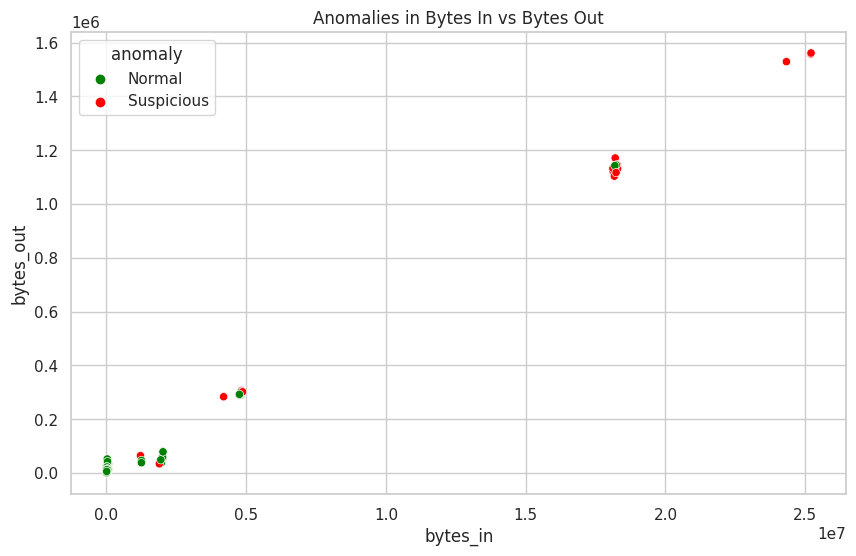

In [54]:
# Select features
features = df[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]

# Model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso_forest.fit_predict(features)

# Convert label to readable
df['anomaly'] = df['anomaly'].map({1: 'Normal', -1: 'Suspicious'})
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly', data=df, palette=['green', 'red'])
plt.title("Anomalies in Bytes In vs Bytes Out")
plt.show()


The scatter plot displays "bytes_in" versus "bytes_out," distinguishing normal (green) and suspicious (red) events. Both normal and suspicious points cluster at lower byte values, but suspicious events are also present at higher byte ranges, especially where both bytes_in and bytes_out are large. This suggests that while most activity is routine, anomalous (suspicious) events tend to involve unusually large data transfers, which could indicate potential security threats or data exfiltration attempts. Normal and suspicious activities overlap at lower byte values, but only suspicious events appear at the highest transfer sizes.

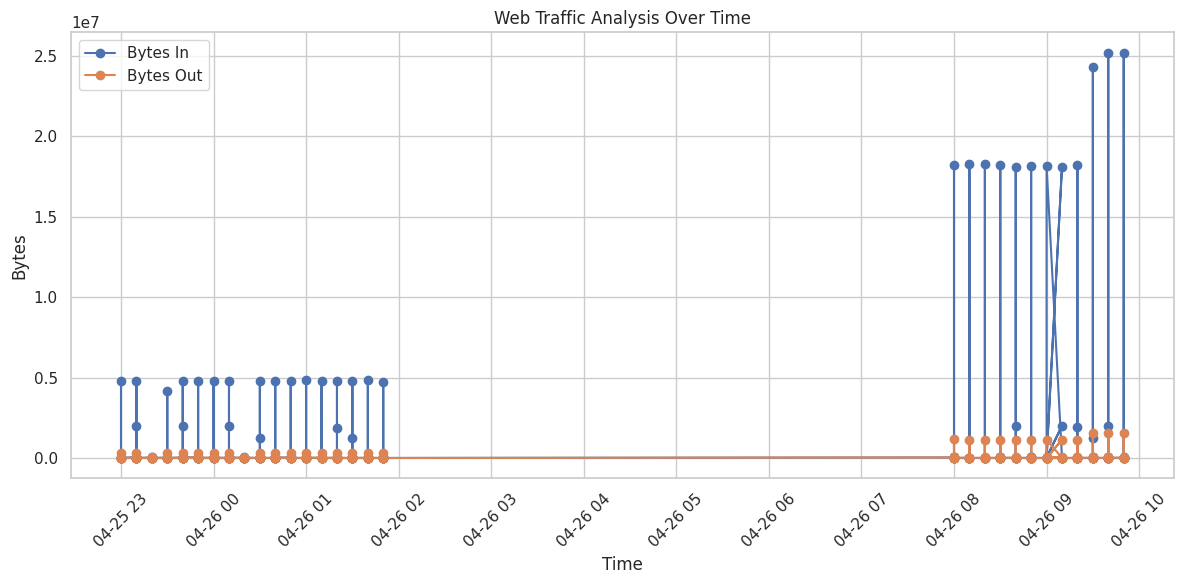

In [62]:
df.set_index('creation_time', inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['bytes_in'], label='Bytes In',
marker='o')
plt.plot(df.index, df['bytes_out'], label='Bytes Out',
marker='o')
plt.title('Web Traffic Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

The graph shows web traffic (Bytes In and Bytes Out) over time. There are two distinct periods of activity separated by a long gap with no traffic. In both active periods, "Bytes In" (blue) values are much higher and more variable than "Bytes Out" (orange), which remain consistently low. In the second active period, "Bytes In" spikes to significantly higher values than in the first, indicating a surge in inbound data. This pattern suggests intermittent bursts of web activity, with the later burst involving much larger inbound transfers, while outbound traffic stays minimal throughout.

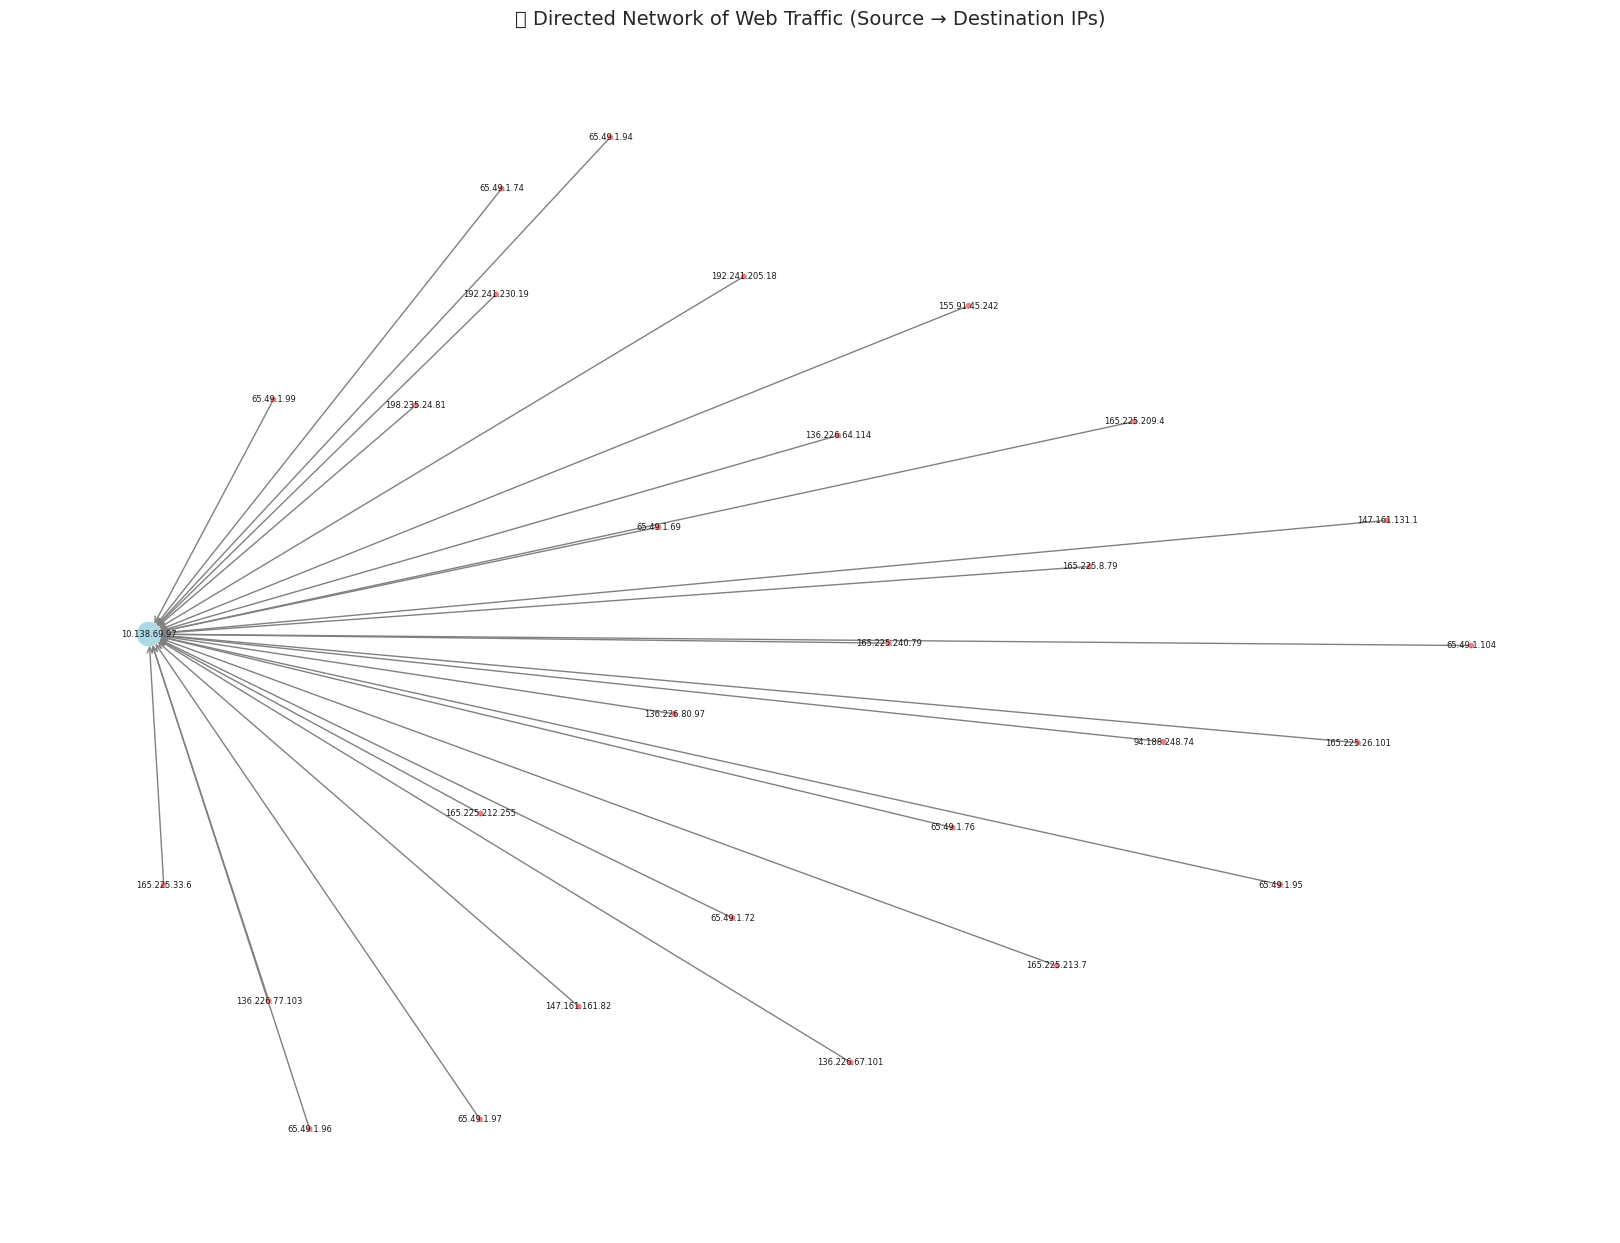

In [65]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Create a directed graph
G = nx.DiGraph()

# Step 2: Add edges from source to destination IP
for idx, row in df.iterrows():
    src = row['src_ip']
    dst = row['dst_ip']
    if pd.notnull(src) and pd.notnull(dst):
        G.add_edge(src, dst)

# Step 3: Compute node sizes (based on degree)
node_sizes = [G.degree(node) * 10 for node in G.nodes]

# Step 4: Color source nodes differently from destination nodes
color_map = []
for node in G.nodes:
    if node in df['src_ip'].values:
        color_map.append('lightcoral')  # Source IP
    else:
        color_map.append('lightblue')   # Destination IP

# Step 5: Layout and draw
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=0.2)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_sizes,
    node_color=color_map,
    font_size=6,
    edge_color='gray',
    arrows=True,
    arrowstyle='->',
    arrowsize=10
)

plt.title('🔁 Directed Network of Web Traffic (Source → Destination IPs)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


The directed network graph shows that the internal IP 10.10.10.10 is initiating outbound connections to a large number of unique external destination IPs. This pattern suggests either broad legitimate web activity (such as a server or gateway communicating with many services) or, if unexpected, could indicate suspicious behavior like scanning or data exfiltration. The exclusive outbound flow and diversity of destinations highlight 10.10.10.10 as a highly active node whose traffic should be reviewed for normalcy or anomalies

#  Model Evaluation

In [55]:
# Class distribution
df['anomaly'].value_counts()

anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64

In [60]:
df[df['anomaly'] == 'Suspicious'].head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,session_duration,avg_packet_size,anomaly
36,4190330,283456,2024-04-25 23:30:00+00:00,2024-04-25 23:40:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:30:00+00:00,waf_rule,600.0,7456.310000,Suspicious
87,1215594,64362,2024-04-26 00:30:00+00:00,2024-04-26 00:40:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 00:30:00+00:00,waf_rule,600.0,2133.260000,Suspicious
116,4827283,306181,2024-04-26 01:00:00+00:00,2024-04-26 01:10:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 01:00:00+00:00,waf_rule,600.0,8555.773333,Suspicious
132,1889834,34306,2024-04-26 01:20:00+00:00,2024-04-26 01:30:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 01:20:00+00:00,waf_rule,600.0,3206.900000,Suspicious
153,4869181,301752,2024-04-26 01:40:00+00:00,2024-04-26 01:50:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 01:40:00+00:00,waf_rule,600.0,8618.221667,Suspicious


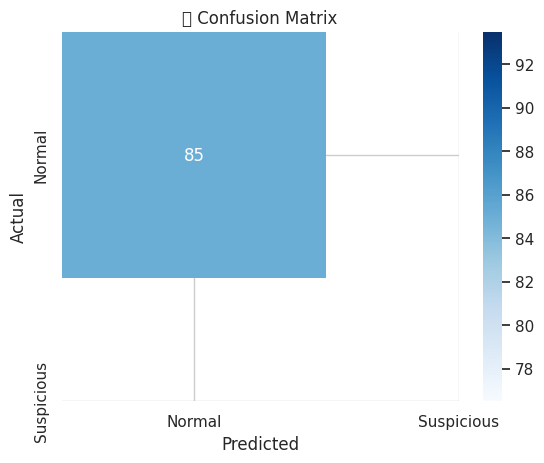

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)

X =df[['bytes_in', 'bytes_out', 'session_duration']]  # Numerical features
y = df['is_suspicious']  # Binary target: 0 (Normal), 1 (Suspicious)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

# plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Suspicious'],
            yticklabels=['Normal', 'Suspicious'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🧾 Confusion Matrix")
plt.show()

In [78]:
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print( classification_report(y_test, y_pred))

✅ Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85

